# LearnMoore Technical Assessment 

In [1]:
# Initialize Notebook
import math as m
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import json
import json5
import ast
import os
from pathlib import Path
from IPython.display import display, Image



# --- Import data ---
jsonl_path = Path(r"Data/response.jsonl")
csv_path = Path(r"Data/data.csv")

response = []                                                                                                        
with open(jsonl_path, 'r') as f:
    for line in f:
        response.append(json.loads(line))

data = pd.read_csv(csv_path)

# Part 1: Parsing Data

In [2]:
def show_structure(d, indent=0):
    print("  " * indent +"{")
    for key, value in d.items():
        print("  " * (indent+1) + str(key) + ": " + type(value).__name__ + ",")
        if isinstance(value, dict):
            show_structure(value, indent + 1)
        if isinstance(value, list):
            entry = value[0]
        # elif isinstance(value, list):
        #     show_structure(value[0], indent + 1)
    
    print("  " * indent +"}")
example = response[0]

show_structure(example)

print("-"*24 + "\nExample Token:")
example["output"]["tokens"][0]

{
  qid: int,
  system: str,
  input: str,
  output: dict,
  {
    content: str,
    tokens: list,
  }
}
------------------------
Example Token:


{'top_token': '{\n',
 'top_100': {'{\n': 0.8603515625,
  'Response': 0.03961181640625,
  'Here': 0.0289764404296875,
  '{\n\n': 0.0157623291015625,
  '"': 0.0101776123046875,
  'Based': 0.00856781005859375,
  'The': 0.005279541015625,
  'I': 0.004375457763671875,
  'Pass': 0.0035152435302734375,
  '{"': 0.0034618377685546875,
  'Ch': 0.0014543533325195312,
  'There': 0.0014314651489257812,
  '{': 0.0012149810791015625,
  'A': 0.0011959075927734375,
  'When': 0.0009031295776367188,
  'This': 0.000888824462890625,
  'To': 0.0006604194641113281,
  '"A': 0.0006208419799804688,
  'Given': 0.0005521774291992188,
  'Since': 0.0004649162292480469,
  'In': 0.00042319297790527344,
  ' Response': 0.0003676414489746094,
  '"B': 0.0003428459167480469,
  'Although': 0.0003428459167480469,
  '**': 0.00033736228942871094}}

In [3]:
# Your code goes here



# Part 2: Experimental Design



We prompted 11 LLMs on 6 question sets. Some of these question sets had models give a distribution that each answer was correct. For example:


A: 50%  <br>
B: 25%  <br>
C: 5%   <br>
D: 20%  <br>

Other question sets had True/False answers where we had the model output the probability it was correct. 

To reduce costs, we submitted our prompts in batches (think a couple hundred prompts at a time). While this worked most of the time we still had some responses fail in generation. Here's some more information on each question set in particular.

| Question Set | Length | Answer Fields | Context | Task Description |
| :--- | :---  | :--- | :--- | :--- |
| **BoolQ** | 3270 |  True, False | None | True or False trivia questions |
| **SciQ** | 1000 |  A, B, C, D | None | Scientific trivia questions |
| **LSAT-AR** | 230 |  A, B, C, D, E | Premise for logical question | Find optimal solution for complex situation |
| **SAT-EN** | 206 |  A, B, C, D | Passage | Answering questions about a reading passage |
| **HaluEval-QA** | 2000 |  N/A | Short passage | Pre-generated Model responses to questions |
| **LifeEval** | 808 |  Predicted age at death | Sex, Minimum Age | Estimate age at death given minimum age and sex |

We had all models respond in a JSON format. For example:

```
{
    "Reasoning": "The passage describes a scene where Akira, a young man, visits Chie's home and asks for her daughter Naomi's hand in marriage. Chie is taken aback by the sudden proposal and is unsure of how to respond. The passage focuses on the interaction between Akira and Chie, and the surprise and uncertainty that Akira's request brings. Therefore, the best answer is the one that describes a character receiving a surprising request from another character.",
    "Answer": "B",
    "A": "0.0",
    "B": "1.0",
    "C": "0.0",
    "D": "0.0"
}

```
**Your Task:**
Think about some issues that may show up. How can we pre-process our data before analysis to mitigate issues and improve the veracity of our results?

# Part 3:  Data Analysis

See what you can find by looking at `data`

In [4]:
qsets  = data["Question Set"].unique()
models = data["Model"].unique()
print(f"Question Sets:{[q for q in qsets]}")
print(f"Models: {[m for m in models]}")
data.tail()

Question Sets:['BoolQ', 'HaluEval', 'LifeEval', 'LSAT-AR', 'SAT-EN', 'SciQ']
Models: ['Claude-Sonnet-3.7', 'Claude Haiku 3', 'Claude-Sonnet-4', 'DeepSeek-R1', 'DeepSeek-V3', 'Gemini-2.5-Flash', 'Gemini-2.5-Pro', 'GPT-4o', 'GPT-o3', 'Llama-3.1-70B', 'Llama-3.1-8B']


,Reasoning,Answer,Stated Confidence Answer,Coerce,Content,Question ID,Model,Model Type,Question Set,Score,...,Token Probability True,Token Probability False,Token Probability Answer,Token Probability A,Token Probability B,Token Probability C,Token Probability D,Token Probability E,gini,combined_name
69273,Predation is a biological process where one sp...,A,NaN,True,"{\n""Reasoning"": ""Predation is a biological pro...",995,Llama-3.1-8B,Llama,SciQ,1.0,...,NaN,NaN,NaN,0.999986,0.000003,0.000001,9.645942e-06,NaN,0.966667,995_SciQ
69274,Short period comets are thought to originate f...,A,NaN,True,"{\n""Reasoning"": ""Short period comets are thoug...",996,Llama-3.1-8B,Llama,SciQ,1.0,...,NaN,NaN,NaN,0.999989,0.000004,0.000004,2.966547e-06,NaN,0.966667,996_SciQ
69275,The question is asking about the developmental...,D,NaN,True,"{\n""Reasoning"": ""The question is asking about ...",997,Llama-3.1-8B,Llama,SciQ,1.0,...,NaN,NaN,NaN,0.000175,0.000042,0.000043,9.997405e-01,NaN,1.000000,997_SciQ
69276,Atoms with unstable nuclei are those that have...,D,NaN,True,"{\n""Reasoning"": ""Atoms with unstable nuclei ar...",998,Llama-3.1-8B,Llama,SciQ,1.0,...,NaN,NaN,NaN,0.000015,0.000018,0.000010,9.999572e-01,NaN,1.000000,998_SciQ
69277,Atmospheric sulfur is primarily found in the f...,C,NaN,True,"{\n""Reasoning"": ""Atmospheric sulfur is primari...",999,Llama-3.1-8B,Llama,SciQ,1.0,...,NaN,NaN,NaN,0.000011,0.000008,0.999980,8.449691e-07,NaN,0.866667,999_SciQ


In [5]:
# Your code goes here:



# Part 4: Drawing Conclusions

Take a look at some of the plots we've generated. Tell us what stands out to you.

File: OC_by_radii.png


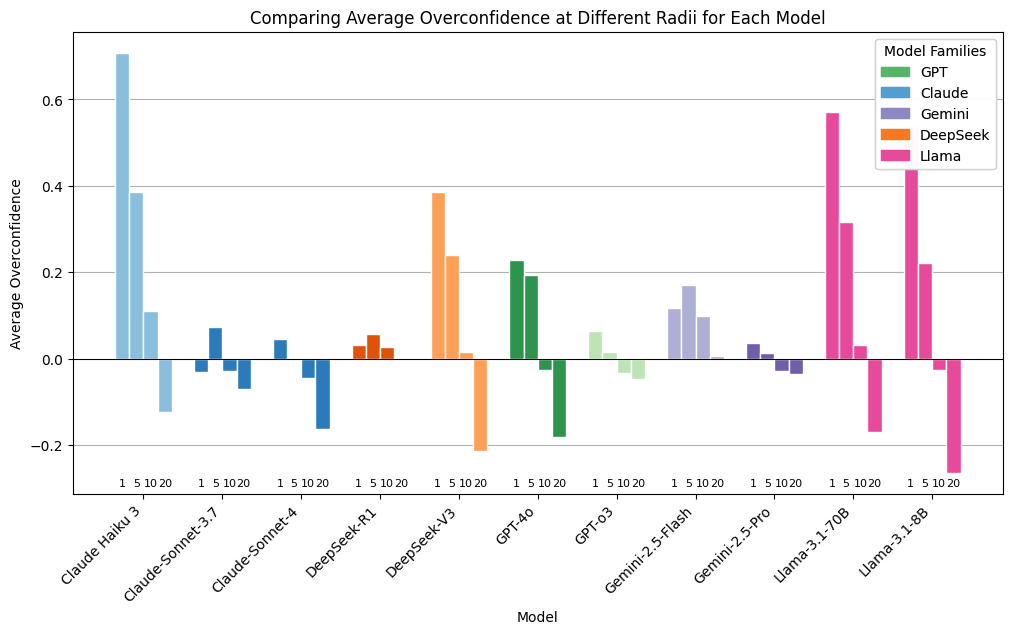

File: agg_cal_plot_mcq.png


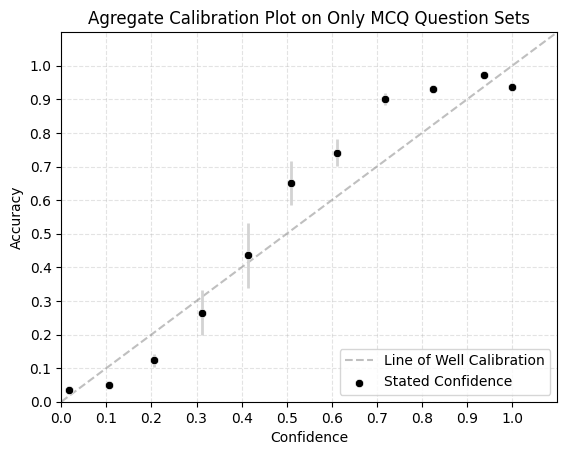

File: deepseek_cal_plot.png


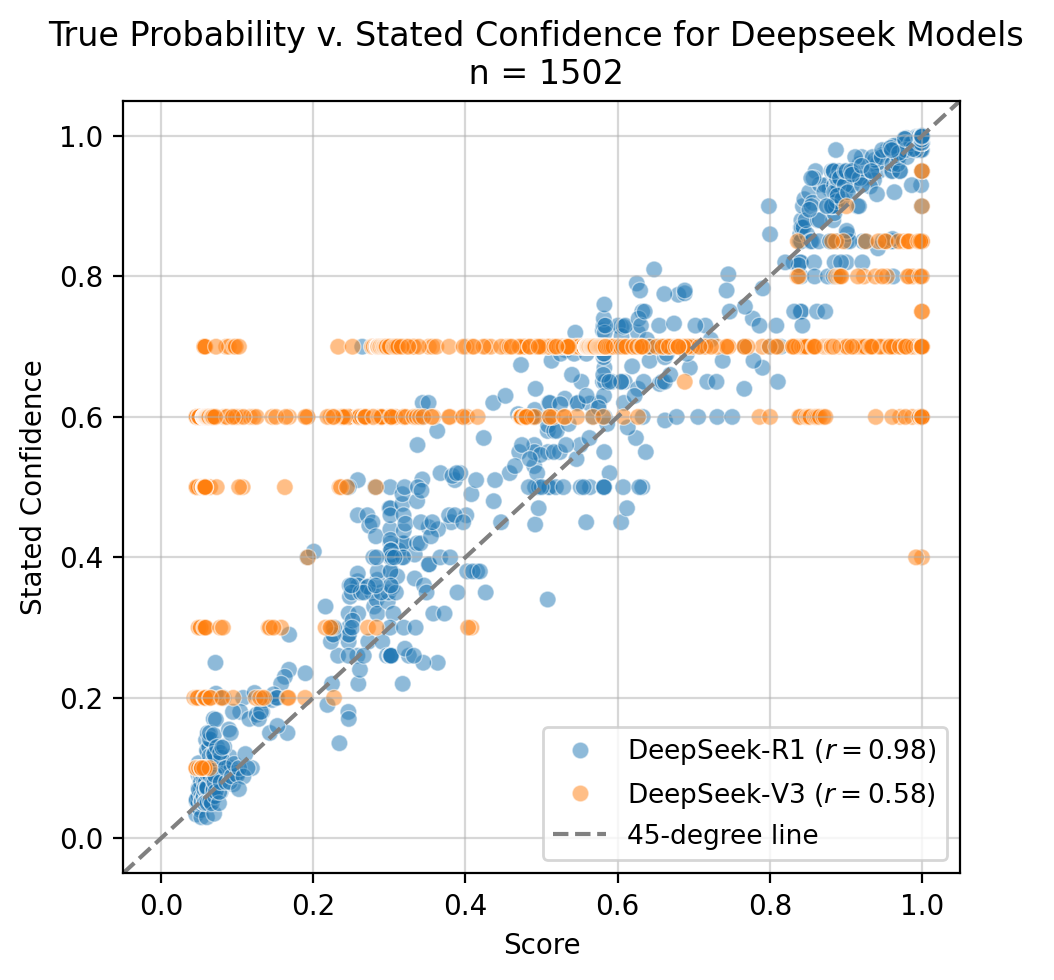

File: oc_by_qset.png


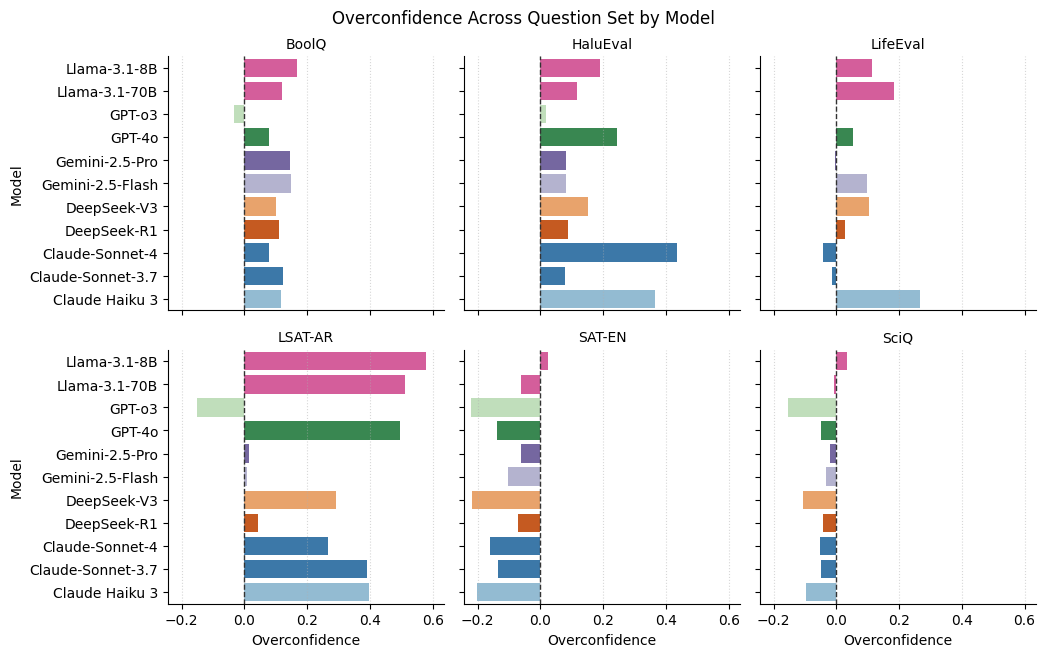

In [6]:
folder_path = 'Figures'

if os.path.exists(folder_path):
    files = [f for f in os.listdir(folder_path) if f.endswith('.png')]
    
    for file in sorted(files):
        print(f"File: {file}")
        display(Image(filename= os.path.join(folder_path, file)))